In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiments-comments/combined_comment_with.csv


In [2]:
!pip install -q --upgrade nltk gensim wordcloud textblob pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 40.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [3]:
import nltk, gensim, wordcloud, textblob, pyLDAvis, sklearn, scipy, matplotlib
print("All good! scikit-learn:", sklearn.__version__)

All good! scikit-learn: 1.2.2


In [4]:
import pandas as pd, re, json, itertools, collections, warnings, os, random, nltk, matplotlib.pyplot as plt, seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from gensim import corpora, models
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

In [5]:
nltk.download('vader_lexicon'); nltk.download('stopwords');

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:

FILE = "/kaggle/input/sentiments-comments/combined_comment_with.csv"
df   = pd.read_csv(FILE)

assert 'comment' in df.columns, "Expected a 'comment' column"
df.head()


,comment,replies,date,Time,user_name,duration
0,Mustâ€™ve had people SHOOK,[],2024-04-26,02:09:22,@TuaTagovailoaTouchdowns,0 days 02:09:22
1,Fuck cnn. ðŸ˜‚,[],2024-04-10,22:01:04,@ZealousZ_,0 days 22:01:04
2,CNN is way out of line !!!!! The owners who r...,[],2024-04-08,10:11:39,@user-jz7gz9ud2v,0 days 10:11:39
3,åœ°éœ‡,[],2024-04-08,00:10:27,@thomasoup,0 days 00:10:27
4,"Where was the second reporter from,..? ðŸ¤”",[],2024-04-07,05:02:49,@Justusson,0 days 05:02:49


In [7]:
stop_words = ENGLISH_STOP_WORDS.union({"https","http","amp"})

tok_re  = re.compile(r"[A-Za-z']+")
def tokenize(text):
    return [t.lower() for t in tok_re.findall(str(text))
            if t.lower() not in stop_words and len(t) > 1]

df["tokens"] = df["comment"].map(tokenize)
df["clean"]  = df["tokens"].str.join(" ")

print("Corpus size:", df.shape[0], "comments")

Corpus size: 1201 comments


 Sentiment analysis (VADER rule-based)

In [8]:
sia = SentimentIntensityAnalyzer()
def vader_classify(text):
    c = sia.polarity_scores(text)["compound"]
    lab = "Positive" if c >= 0.05 else "Negative" if c <= -0.05 else "Neutral"
    return pd.Series([c, lab])

df[["compound","sentiment"]] = df["comment"].apply(vader_classify)

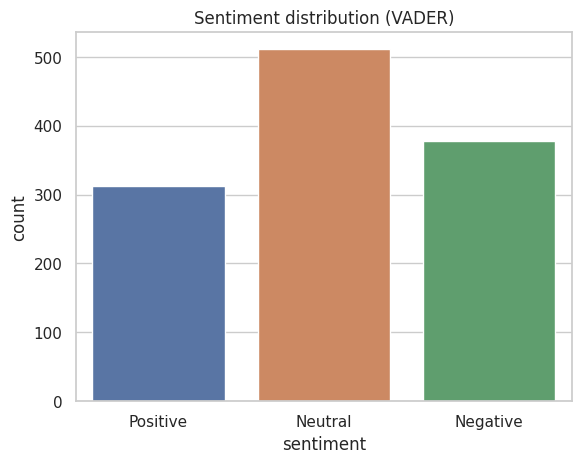

In [9]:
sns.countplot(x="sentiment", data=df, order=["Positive","Neutral","Negative"])
plt.title("Sentiment distribution (VADER)"); plt.show()

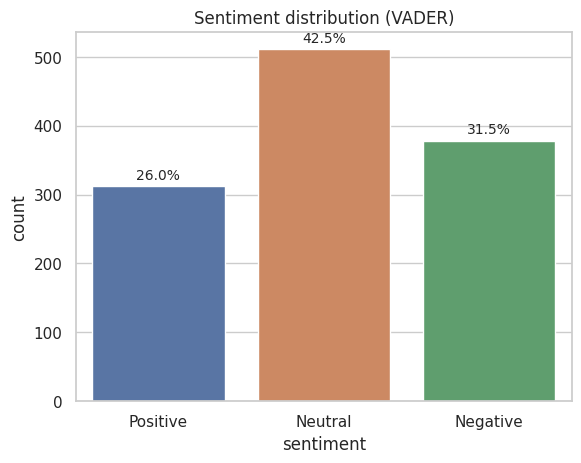

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.countplot(
    x="sentiment",
    data=df,
    order=["Positive", "Neutral", "Negative"]
)
plt.title("Sentiment distribution (VADER)")


total = len(df)                       # total number of rows
for p in ax.patches:                  # iterate over every drawn bar
    height = p.get_height()
    pct = f'{100*height/total:.1f}%'  # one-decimal-place %
    ax.annotate(
        pct,
        xy=(p.get_x() + p.get_width() / 2, height),   # x,y position
        xytext=(0, 3),                                # 3 points above bar
        textcoords='offset points',
        ha='center', va='bottom', fontsize=10
    )

plt.show()

In [11]:
import pandas as pd, re, collections, matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from textblob import TextBlob


# Sentiment label (keep existing column if present)
if 'sentiment' not in df.columns:
    def sentiment_tb(text):
        p = TextBlob(str(text)).sentiment.polarity
        if p >= 0.05: return 'Positive'
        elif p <= -0.05: return 'Negative'
        else: return 'Neutral'
    df['sentiment'] = df['comment'].apply(sentiment_tb)

In [12]:
# Tokenisation
stop_words = set(ENGLISH_STOP_WORDS)
tok_re = re.compile(r"[A-Za-z']+")

def tokens(series):
    toks = []
    for txt in series:
        toks += [t.lower() for t in tok_re.findall(str(txt))
                 if t.lower() not in stop_words and len(t) > 1]
    return toks

# Token frequency per sentiment
freq = {lab: collections.Counter(tokens(df[df.sentiment==lab]['comment']))
        for lab in ['Positive','Neutral','Negative']}


In [13]:
#tokens that appear multiple times in sentiment groups
intersect = set()
labels = ['Positive','Neutral','Negative']
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        intersect |= (set(freq[labels[i]].keys()) & set(freq[labels[j]].keys()))


In [14]:
# EXCLUSIVE word clouds
exclusive_freq = {lab: collections.Counter({w:c for w,c in freq[lab].items() if w not in intersect})
                  for lab in labels}

# TF-IDF-style "distinctiveness" weighting
import math
total_docs = len(labels)
idf = {w: math.log(total_docs / sum(1 for lab in labels if w in freq[lab])) for w in set().union(*[freq[l].keys() for l in labels])}
distinct_freq = {
    lab: {w: c * idf[w] for w,c in freq[lab].items()}
    for lab in labels
}

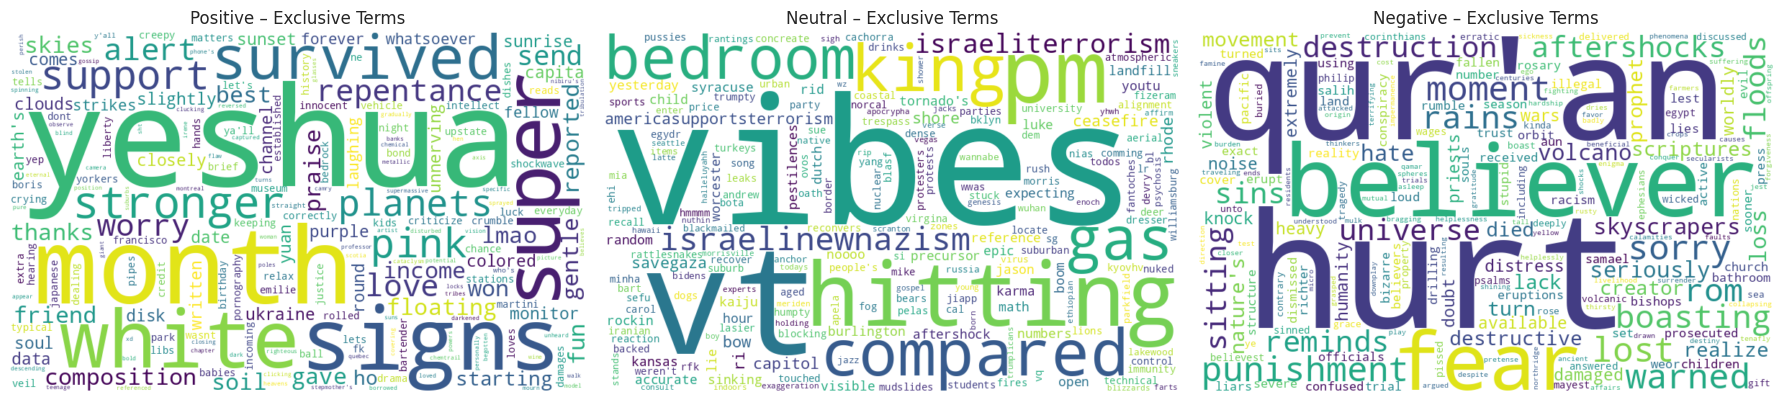

In [15]:
# Plot exclusive word clouds
plt.figure(figsize=(18,6))
for idx, lab in enumerate(labels,1):
    wc = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(exclusive_freq[lab])
    plt.subplot(1,3,idx)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{lab} – Exclusive Terms")
plt.tight_layout()
plt.show()

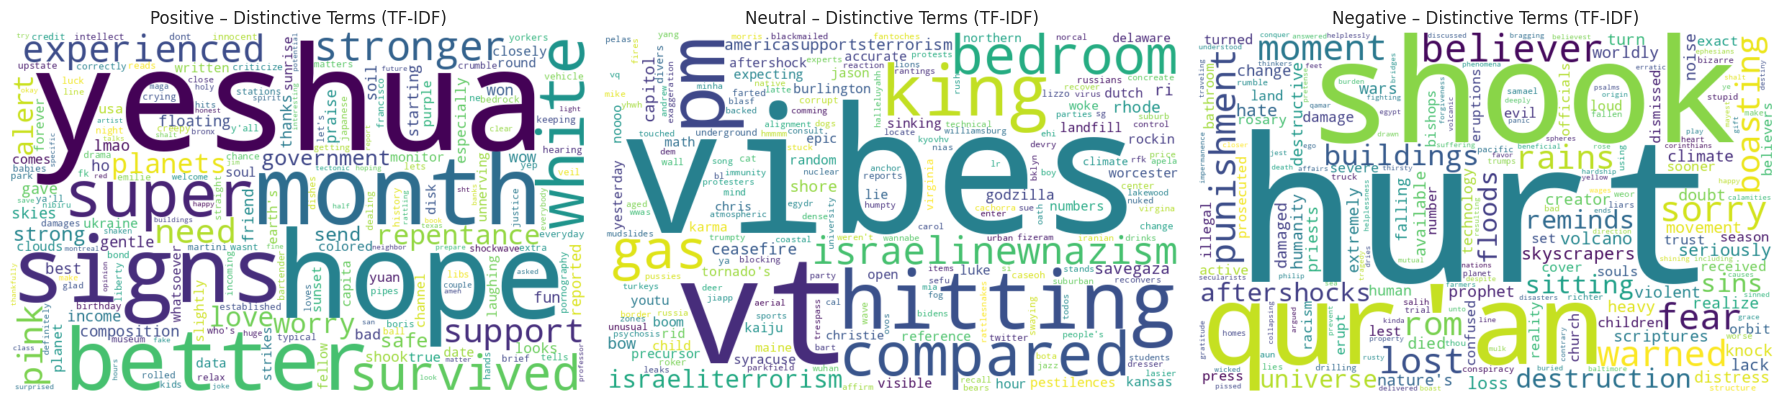

In [16]:

# Plot distinctiveness-weighted word clouds (TF‑IDF-ish)
plt.figure(figsize=(18,6))
for idx, lab in enumerate(labels,1):
    wc = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(distinct_freq[lab])
    plt.subplot(1,3,idx)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{lab} – Distinctive Terms (TF‑IDF)")
plt.tight_layout()
plt.show()


## 3  Bag-of-words + TF–IDF salience

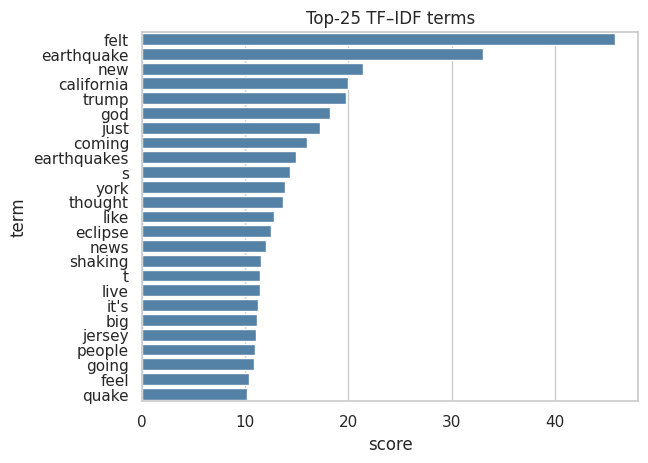

In [17]:
tfidf  = TfidfVectorizer(stop_words="english", token_pattern=r"[A-Za-z']+")
Xtfidf = tfidf.fit_transform(df["comment"])
scores  = Xtfidf.sum(axis=0).A1
terms   = tfidf.get_feature_names_out()

top = pd.DataFrame(dict(term=terms, score=scores)).nlargest(25,"score")
sns.barplot(y="term", x="score", data=top, color="steelblue")
plt.title("Top-25 TF–IDF terms"); plt.show()

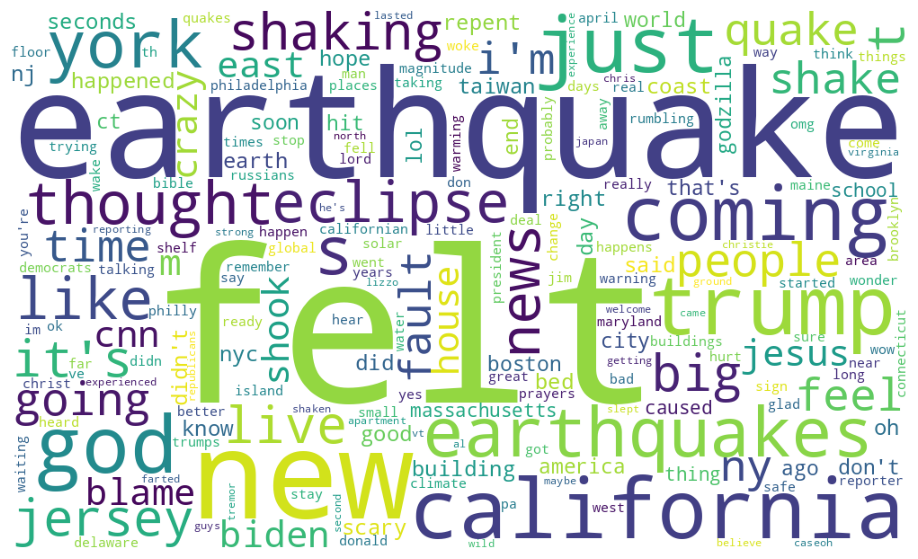

In [18]:
wc = WordCloud(width=1000,height=600,background_color="white")
wc.generate_from_frequencies(dict(zip(terms,scores)))
plt.figure(figsize=(12,7)); plt.imshow(wc); plt.axis('off'); plt.show()

## 4  Bigram collocations

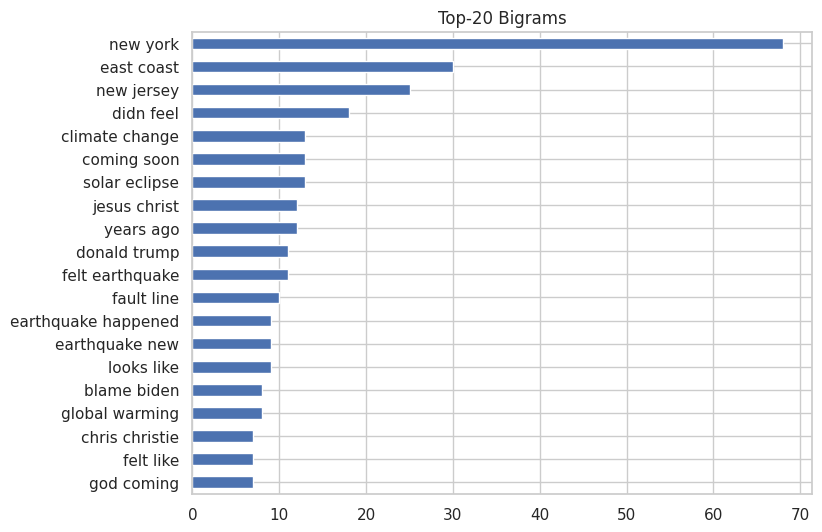

In [19]:
cv2 = CountVectorizer(stop_words="english", ngram_range=(2,2), min_df=5)
Xbi = cv2.fit_transform(df["clean"])
bigrams = pd.Series(Xbi.sum(axis=0).A1, index=cv2.get_feature_names_out())
bigrams.nlargest(20).plot(kind="barh", figsize=(8,6)); plt.title("Top-20 Bigrams"); plt.gca().invert_yaxis(); plt.show()

## 5  LDA topic modelling (machine-learning component)

In [20]:
dictionary = corpora.Dictionary(df["tokens"])
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=5000)
corpus     = [dictionary.doc2bow(toks) for toks in df["tokens"]]
print("Vocab after filter:", len(dictionary))

Vocab after filter: 443


In [21]:
NUM_TOPICS = 5
lda = models.LdaModel(
        corpus=corpus, id2word=dictionary,
        num_topics=NUM_TOPICS, random_state=0,
        chunksize=2000, passes=10, alpha='auto')

for i in range(NUM_TOPICS):
    print(f"\nTopic {i+1}: ", lda.print_topic(i, topn=10))



Topic 1:  0.077*"earthquake" + 0.069*"new" + 0.040*"york" + 0.027*"like" + 0.024*"jersey" + 0.018*"shaking" + 0.018*"just" + 0.018*"felt" + 0.017*"house" + 0.017*"shook"

Topic 2:  0.057*"california" + 0.043*"earthquake" + 0.030*"thought" + 0.025*"east" + 0.025*"felt" + 0.021*"coast" + 0.019*"big" + 0.018*"nj" + 0.015*"i'm" + 0.014*"time"

Topic 3:  0.079*"felt" + 0.021*"coming" + 0.019*"eclipse" + 0.018*"quake" + 0.017*"ny" + 0.015*"just" + 0.014*"god" + 0.014*"people" + 0.014*"live" + 0.013*"like"

Topic 4:  0.044*"god" + 0.023*"jesus" + 0.022*"felt" + 0.020*"coming" + 0.019*"earthquakes" + 0.018*"soon" + 0.018*"sky" + 0.015*"life" + 0.014*"world" + 0.013*"shall"

Topic 5:  0.058*"trump" + 0.022*"cnn" + 0.021*"biden" + 0.021*"news" + 0.020*"blame" + 0.019*"it's" + 0.018*"going" + 0.018*"that's" + 0.017*"just" + 0.016*"feel"


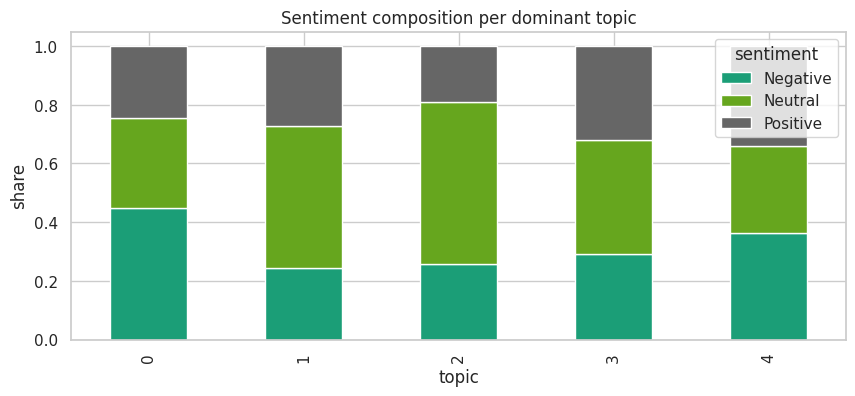

In [22]:
# Map topic
def dominant_topic(bow):
    topics = lda.get_document_topics(bow, minimum_probability=0.0)
    return max(topics, key=lambda x: x[1])[0]

df["topic"] = [dominant_topic(b) for b in corpus]

# Crosstab sentiment × topic
sent_topic = pd.crosstab(df["topic"], df["sentiment"], normalize="index")
sent_topic.plot(kind="bar", stacked=True, colormap="Dark2",
                figsize=(10,4), legend=True)
plt.title("Sentiment composition per dominant topic"); plt.ylabel("share"); plt.show()

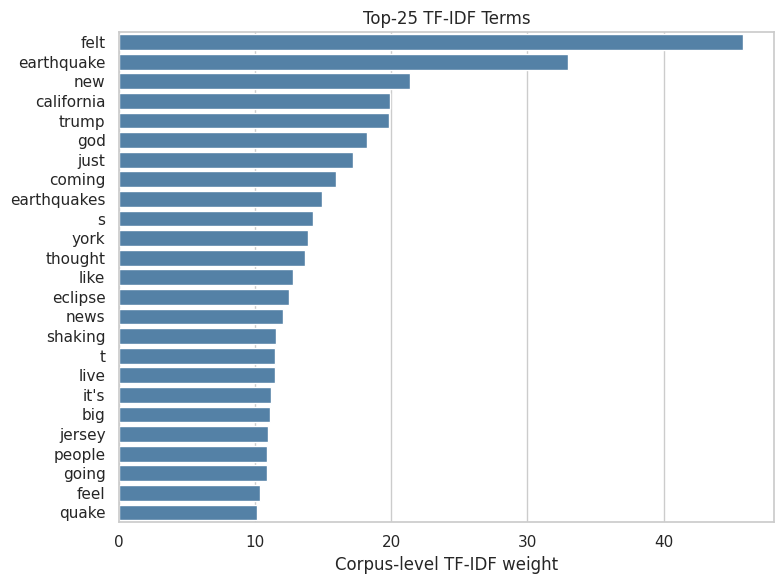

In [23]:
# TF-IDF salience 
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

tfidf  = TfidfVectorizer(
            stop_words="english",
            token_pattern=r"[A-Za-z']+"   # keeps words like don't, it's
         )

Xtfidf = tfidf.fit_transform(df["comment"])  # or df["clean"]

# Sum TF-IDF weights across all documents
scores  = Xtfidf.sum(axis=0).A1
terms   = tfidf.get_feature_names_out()

# Build DataFrame of top-N terms
top_n = 25
top = (pd.DataFrame({"term": terms, "score": scores})
         .nlargest(top_n, "score"))

# Bar-plot
plt.figure(figsize=(8,6))
sns.barplot(y="term", x="score", data=top, color="steelblue")
plt.title(f"Top-{top_n} TF-IDF Terms")
plt.xlabel("Corpus-level TF-IDF weight")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [24]:
pip install nrclex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43308 sha256=5c1ffab3229800a084a089b65a08394466a42a7304bbb678ecb6f377e6e5dd7e
  Stored in directory: /root/.cache/pip/wheels/ed/ac/fa/7afddefd14f51c4a963ed291b9052746ed3929473e5a33118d
Successfully built nrclex
Note: you may need to restart the kernel to use updated packages.


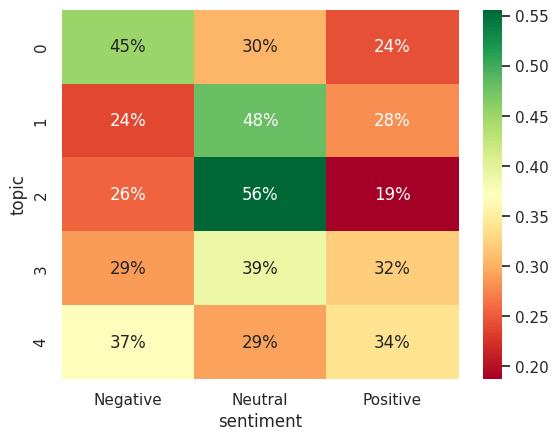

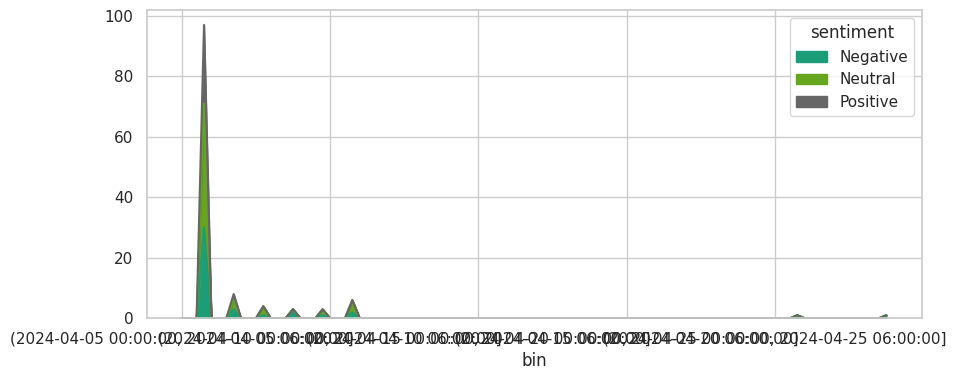

In [25]:
# 1) Emotion tagging -------------------------------------------------
from nrclex import NRCLex
df['emotion'] = df['comment'].apply(
    lambda t: NRCLex(str(t)).top_emotions[0][0] if NRCLex(str(t)).top_emotions else 'none'
)

# 2) Topic-by-sentiment cross-tab -----------------------------------
df['topic'] = [max(lda.get_document_topics(b), key=lambda x: x[1])[0] for b in corpus]
sent_topic = pd.crosstab(df['topic'], df['sentiment'], normalize='index')
sns.heatmap(sent_topic, cmap='RdYlGn', annot=True, fmt='.0%'); plt.show()

# 3) Temporal drift --------------------------------------------------
df['ts']  = pd.to_datetime(df['date'])
df['bin'] = pd.cut(df.ts, bins=pd.date_range(df.ts.min(), df.ts.max(), freq='6H'))
sent_time = df.groupby(['bin','sentiment']).size().unstack(fill_value=0)
sent_time.plot.area(colormap='Dark2', stacked=True, figsize=(10,4)); plt.show()


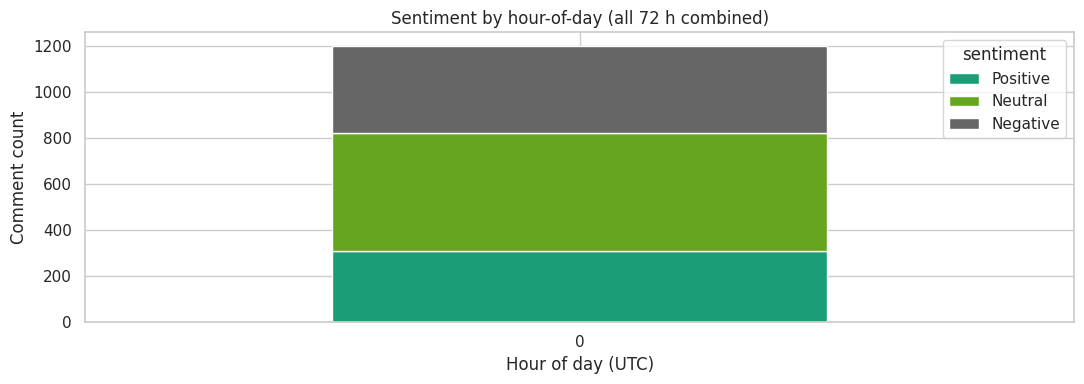

In [26]:
# ----------------------------------------------------------
# 1) convert to datetime & extract hour of day
df['ts'] = pd.to_datetime(df['date'])
df['hour'] = df['ts'].dt.hour           # 0 … 23

# 2) count sentiments per hour across all three days
hourly = (
    df.groupby(['hour', 'sentiment'])
      .size().unstack(fill_value=0)
      .reindex(columns=['Positive','Neutral','Negative'])
      .sort_index()
)

# 3) bar chart
ax = hourly.plot(kind='bar', stacked=True, figsize=(11,4), colormap='Dark2')
ax.set_xlabel('Hour of day (UTC)')
ax.set_ylabel('Comment count')
ax.set_title('Sentiment by hour-of-day (all 72 h combined)')
plt.xticks(rotation=0); plt.tight_layout(); plt.show()


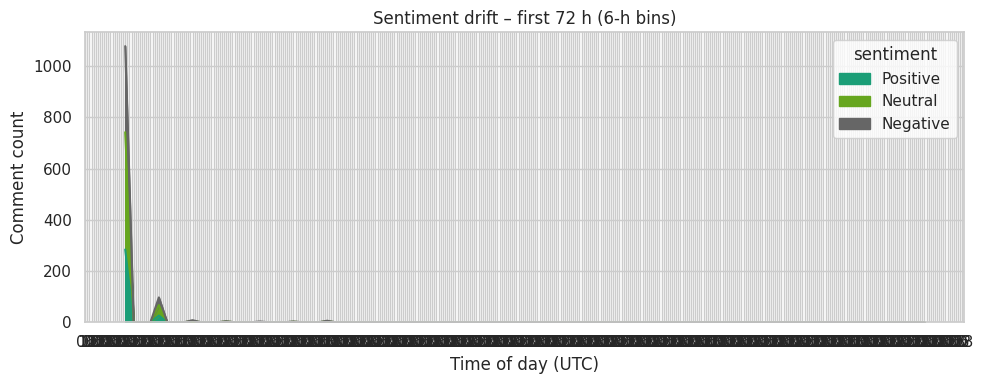

In [27]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# --- build the 6-hour binned table exactly as before ----------------
df['ts']  = pd.to_datetime(df['date'])
bins      = pd.date_range(df.ts.min().floor('H'),
                          df.ts.max().ceil('H'),
                          freq='6H')
df['bin'] = pd.cut(df.ts, bins=bins, right=False, labels=bins[:-1])

sent_time = (
    df.groupby(['bin', 'sentiment'])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=['Positive','Neutral','Negative'])   # keep order
)

# --- plot: time-of-day only ----------------------------------------
ax = sent_time.plot.area(colormap='Dark2', figsize=(10,4))

# show a tick at every 6-h mark
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
# format HOURS only
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.xlabel('Time of day (UTC)')        # or local zone if converted earlier
plt.ylabel('Comment count')
plt.title('Sentiment drift – first 72 h (6-h bins)')
plt.xticks(rotation=0)                 # keep horizontal since labels are short
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd, re, itertools, collections, math, json, warnings
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim import corpora, models
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wordcloud import WordCloud

try:
    import plotly.graph_objects as go
except ImportError:
    !pip -q install plotly
    import plotly.graph_objects as go

In [29]:
stop_words = set(ENGLISH_STOP_WORDS)
token_re   = re.compile(r"[A-Za-z']+")

def tokenize(text:str):
    return [t.lower() for t in token_re.findall(str(text))
            if t.lower() not in stop_words and len(t) > 1]

df['tokens'] = df['comment'].map(tokenize)
df['clean']  = df['tokens'].str.join(' ')


In [30]:
dictionary = corpora.Dictionary(df['tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=5000)
corpus = [dictionary.doc2bow(toks) for toks in df['tokens']]

NUM_TOPICS = 5
lda = models.LdaModel(corpus=corpus, id2word=dictionary,
                      num_topics=NUM_TOPICS, passes=8,
                      random_state=42, alpha='auto', eta='auto')

# Map dominant topic & produce human‑readable labels
def dominant_topic(bow):
    topics = lda.get_document_topics(bow, minimum_probability=0.0)
    return max(topics, key=lambda x: x[1])[0]

df['topic'] = [dominant_topic(b) for b in corpus]

topic_labels = {i: ", ".join([w for w,_ in lda.show_topic(i, topn=5)])
                for i in range(NUM_TOPICS)}


In [31]:
# Sentiment (TextBlob fallback) 
from textblob import TextBlob
def get_sent(text):
    p = TextBlob(str(text)).sentiment.polarity
    if p >= 0.05: return 'Positive'
    if p <= -0.05: return 'Negative'
    return 'Neutral'
df['sentiment'] = df['comment'].map(get_sent)


In [32]:
# Time binning: 6‑hour bins & local datetime -----------------------------
df['ts_utc'] = pd.to_datetime(df['date'])
bins = pd.date_range(df.ts_utc.min().floor('H'),
                     df.ts_utc.max().ceil('H'),
                     freq='6H')
df['bin']  = pd.cut(df.ts_utc, bins=bins, right=False, labels=bins[:-1])


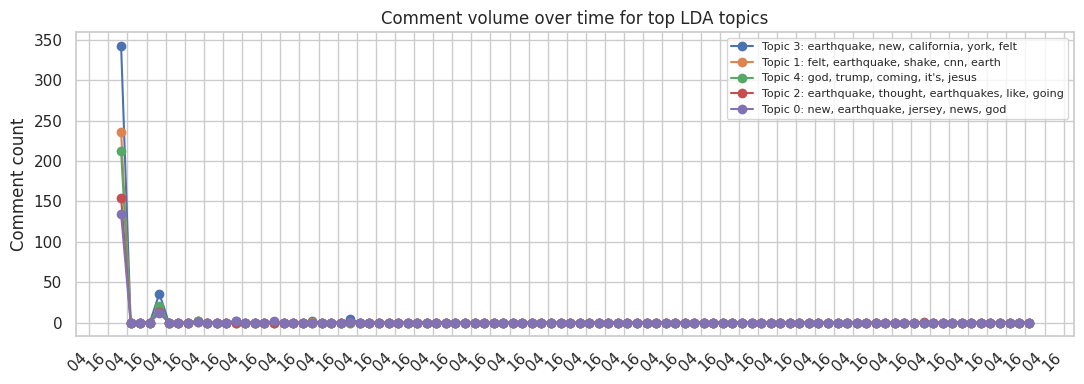

In [33]:
# 1) Separate curves per top topics (counts over time) 
top_topic_ids = df['topic'].value_counts().head(5).index.tolist()
topic_time = (df[df.topic.isin(top_topic_ids)]
              .groupby(['bin','topic'])
              .size()
              .unstack(fill_value=0)
              .sort_index())

plt.figure(figsize=(11,4))
for tid in top_topic_ids:
    plt.plot(topic_time.index, topic_time[tid],
             marker='o', label=f"Topic {tid}: {topic_labels[tid]}")
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xticks(rotation=45, ha='right')
plt.ylabel("Comment count")
plt.title("Comment volume over time for top LDA topics")
plt.legend(fontsize=8, loc='upper right')
plt.tight_layout()
plt.show()

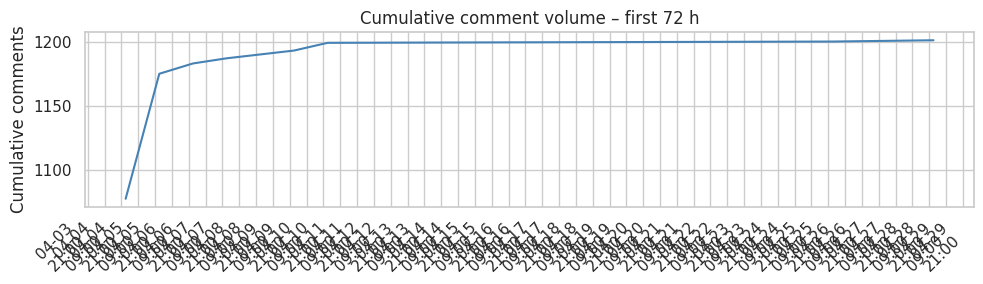

In [34]:
# 2) Cumulative comment curve 
cum = df.groupby('ts_utc').size().sort_index().cumsum()
plt.figure(figsize=(10,3))
plt.plot(cum.index, cum.values, color='steelblue')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
plt.xticks(rotation=45, ha='right')
plt.ylabel("Cumulative comments")
plt.title("Cumulative comment volume – first 72 h")
plt.tight_layout()
plt.show()
